#  Face recognition with LeNet 

Step 1: Organize imports

In [1]:
from sklearn.model_selection import train_test_split  
from keras import backend as K
K.set_image_dim_ordering('th') # this works
from keras.utils import np_utils
from keras.optimizers import SGD, RMSprop, Adam
from keras.models import Sequential  
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D 
from keras.layers.core import Activation  
from keras.layers.core import Flatten  
from keras.layers.core import Dense
from keras.models import model_from_json

Using TensorFlow backend.


In [2]:
import numpy as np  
import cv2  
import os  
import sys 
import argparse 
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
class LeNet:
	@staticmethod
	def build(input_shape, classes):
		model = Sequential()
		# CONV => RELU => POOL
		model.add(Conv2D(20, kernel_size=5, padding="same",
			input_shape=input_shape))
		model.add(Activation("relu"))
		model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
		# CONV => RELU => POOL
		model.add(Conv2D(50, kernel_size=5, padding="same"))
		model.add(Activation("relu"))
		model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
		# Flatten => RELU layers
		model.add(Flatten())
		model.add(Dense(500))
		model.add(Activation("relu"))
 
		# a softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		return model

In [4]:
NB_EPOCH = 200
BATCH_SIZE = 128
VERBOSE = 1
OPTIMIZER = Adam()
VALIDATION_SPLIT=0.2

IMG_ROWS, IMG_COLS = 28, 28 
NB_CLASSES = 10  
INPUT_SHAPE = (1, IMG_ROWS, IMG_COLS)

np.random.seed(1983)  # for reproducibility

Step 2: Define method to load images from subfolders of category

In [5]:
def load_images_from_folders(folders, root_dir):
    print('Acquiring images...')
    images = []
    labels = []
    for folder in folders:        
        for filename in os.listdir(os.path.join(root_dir,folder)):
            if any([filename.endswith(x) for x in ['.jpeg', '.jpg','.pgm','png']]):
                img = cv2.imread(os.path.join(root_dir, folder, filename), cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    image = cv2.resize(img, (IMG_COLS, IMG_ROWS)) 
                    image = np.array(image, 'uint8') # convert to numpy array
                    images.append(image)
                    label = os.path.split(folder)[1].split("_")[1] # number from person_0_
                    labels.append(label)
    return images, labels;

Step 3: Load images from subfolders of category: 10 persons; 50 images each

In [6]:
folders = [
    'person_0_abad',
    'person_1_agui',
    'person_2_cans',
    'person_3_degu',
    'person_4_hato',
    'person_5_libb',
    'person_6_palo',
    'person_7_prim',
    'person_8_rosa',
    'person_9_venu'
]

root_dir = r'C:\Users\cobalt\workspace\FaceRecognition\front_database'

(images, labels) = load_images_from_folders(folders, root_dir)
print('No. of images = %s. ' %  len(images))
print('No. of labels = %s. ' %  len(labels))
print(labels[0])

Acquiring images...
No. of images = 500. 
No. of labels = 500. 
0


Step 4: Plot the first image.

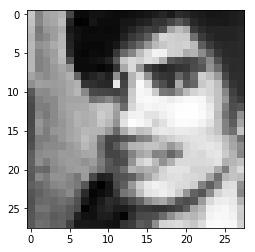

In [7]:
plt.imshow(images[0], cmap='gray')

Step 5: Define method for plotting a person: 50 images 

In [8]:
def plot_person_category(images, id):
    for k in range(50*id,50*id + 50):
        plt.subplot(5, 10, k - (50*id - 1))      
        plt.gca().axes.get_yaxis().set_visible(False)
        plt.gca().axes.get_xaxis().set_visible(False)
        plt.imshow(images[k], cmap='gray')

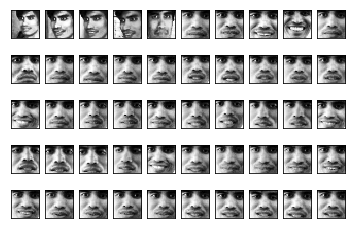

In [9]:
# Plot person 0
plot_person_category(images, 0)

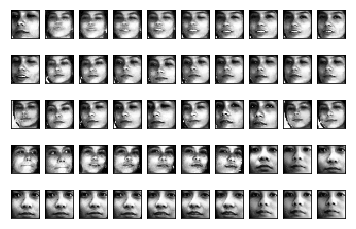

In [10]:
# Plot person 1
plot_person_category(images, 1)

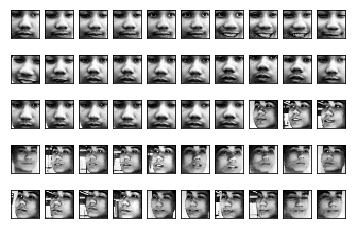

In [11]:
# Plot person 2
plot_person_category(images, 2)

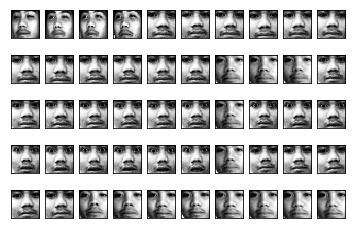

In [12]:
# Plot person 3
plot_person_category(images, 3)

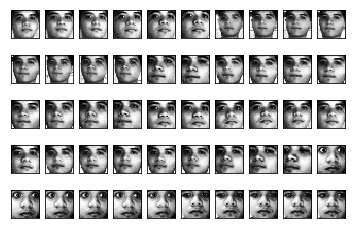

In [13]:
# Plot person 4
plot_person_category(images, 4)

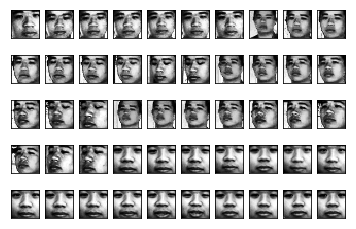

In [14]:
# Plot person 5
plot_person_category(images, 5)

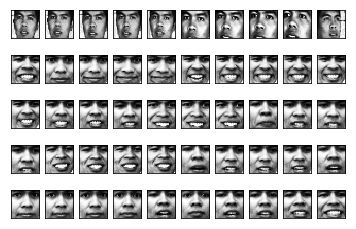

In [15]:
# Plot person 6
plot_person_category(images, 6)

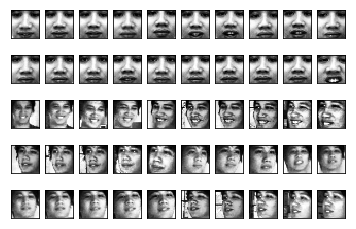

In [16]:
# Plot person 7
plot_person_category(images, 7)

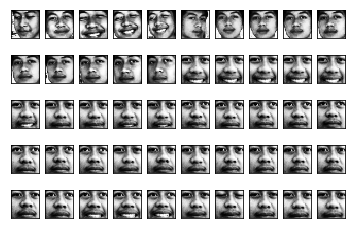

In [17]:
# Plot person 8
plot_person_category(images, 8)

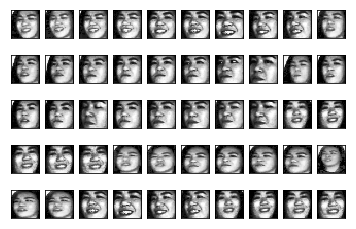

In [18]:
# Plot person 9
plot_person_category(images, 9)

Separate into test and train

In [19]:
(trainData, testData, trainLabels, testLabels) = train_test_split(images, labels, test_size=0.10)

One-Hot Encoding

In [20]:
print('Before: trainLabels[0] = %s' % trainLabels[0])
print('Before: testLabels[0] = %s' % testLabels[0])
trainLabels = np_utils.to_categorical(trainLabels, NB_CLASSES)  
testLabels = np_utils.to_categorical(testLabels, NB_CLASSES) 
print('After: trainLabels[0] = %s' % trainLabels[0])
print('After: testLabels[0] = %s' % testLabels[0])

Before: trainLabels[0] = 9
Before: testLabels[0] = 4
After: trainLabels[0] = [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
After: testLabels[0] = [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]


In [21]:
# Convert to NumPy array
trainData = np.asarray(trainData)  
testData = np.asarray(testData)  

# Convert uint to float32
trainData = trainData.astype('float32')
testData = testData.astype('float32')

# Normalize
trainData /= 255 
testData /= 255

# No. of Samples x [1 x 28 x 28] shape as input to the CONVNET
trainData = trainData[:, np.newaxis, :, :]
testData = testData[:, np.newaxis, :, :]

print(trainData.shape, 'train samples')
print(testData.shape, 'test samples')

(450, 1, 28, 28) train samples
(50, 1, 28, 28) test samples


In [22]:
model = LeNet.build(input_shape=INPUT_SHAPE, classes=NB_CLASSES)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 20, 28, 28)        520       
_________________________________________________________________
activation_1 (Activation)    (None, 20, 28, 28)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 14, 14)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 14, 14)        25050     
_________________________________________________________________
activation_2 (Activation)    (None, 50, 14, 14)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 7, 7)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2450)              0         
__________

In [23]:
model.compile(loss='categorical_crossentropy',
              optimizer=OPTIMIZER,
              metrics=['accuracy'])

In [24]:
history = model.fit(trainData, trainLabels,
                    batch_size=BATCH_SIZE, epochs=NB_EPOCH,
                    verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

Train on 360 samples, validate on 90 samples
Epoch 1/200
360/360 [==============================] - 2s - loss: 2.3452 - acc: 0.1028 - val_loss: 2.2137 - val_acc: 0.3333
Epoch 2/200
360/360 [==============================] - 2s - loss: 2.1671 - acc: 0.3111 - val_loss: 2.0855 - val_acc: 0.2778
Epoch 3/200
360/360 [==============================] - 2s - loss: 1.9784 - acc: 0.3417 - val_loss: 1.8160 - val_acc: 0.4556
Epoch 4/200
360/360 [==============================] - 2s - loss: 1.7140 - acc: 0.4667 - val_loss: 1.5235 - val_acc: 0.6333
Epoch 5/200
360/360 [==============================] - 2s - loss: 1.4624 - acc: 0.5778 - val_loss: 1.4190 - val_acc: 0.4778
Epoch 6/200
360/360 [==============================] - 2s - loss: 1.3565 - acc: 0.4972 - val_loss: 1.3731 - val_acc: 0.5444
Epoch 7/200
360/360 [==============================] - 2s - loss: 1.2495 - acc: 0.5667 - val_loss: 1.2482 - val_acc: 0.5778
Epoch 8/200
360/360 [==============================] - 2s - loss: 1.0745 - acc: 0.6528 

360/360 [==============================] - 2s - loss: 0.0021 - acc: 1.0000 - val_loss: 0.2362 - val_acc: 0.9444
Epoch 67/200
360/360 [==============================] - 2s - loss: 0.0021 - acc: 1.0000 - val_loss: 0.2345 - val_acc: 0.9444
Epoch 68/200
360/360 [==============================] - 2s - loss: 0.0020 - acc: 1.0000 - val_loss: 0.2342 - val_acc: 0.9444
Epoch 69/200
360/360 [==============================] - 2s - loss: 0.0019 - acc: 1.0000 - val_loss: 0.2358 - val_acc: 0.9444
Epoch 70/200
360/360 [==============================] - 2s - loss: 0.0019 - acc: 1.0000 - val_loss: 0.2378 - val_acc: 0.9444
Epoch 71/200
360/360 [==============================] - 2s - loss: 0.0018 - acc: 1.0000 - val_loss: 0.2410 - val_acc: 0.9444
Epoch 72/200
360/360 [==============================] - 2s - loss: 0.0018 - acc: 1.0000 - val_loss: 0.2416 - val_acc: 0.9444
Epoch 73/200
360/360 [==============================] - 2s - loss: 0.0017 - acc: 1.0000 - val_loss: 0.2396 - val_acc: 0.9444
Epoch 74/200


360/360 [==============================] - 2s - loss: 5.8615e-04 - acc: 1.0000 - val_loss: 0.2567 - val_acc: 0.9444
Epoch 131/200
360/360 [==============================] - 2s - loss: 5.7752e-04 - acc: 1.0000 - val_loss: 0.2574 - val_acc: 0.9444
Epoch 132/200
360/360 [==============================] - 2s - loss: 5.6949e-04 - acc: 1.0000 - val_loss: 0.2571 - val_acc: 0.9444
Epoch 133/200
360/360 [==============================] - 2s - loss: 5.6139e-04 - acc: 1.0000 - val_loss: 0.2572 - val_acc: 0.9444
Epoch 134/200
360/360 [==============================] - 2s - loss: 5.5201e-04 - acc: 1.0000 - val_loss: 0.2571 - val_acc: 0.9444
Epoch 135/200
360/360 [==============================] - 2s - loss: 5.4517e-04 - acc: 1.0000 - val_loss: 0.2563 - val_acc: 0.9444
Epoch 136/200
360/360 [==============================] - 2s - loss: 5.3804e-04 - acc: 1.0000 - val_loss: 0.2563 - val_acc: 0.9444
Epoch 137/200
360/360 [==============================] - 2s - loss: 5.3143e-04 - acc: 1.0000 - val_loss:

360/360 [==============================] - 3s - loss: 2.7652e-04 - acc: 1.0000 - val_loss: 0.2671 - val_acc: 0.9444
Epoch 194/200
360/360 [==============================] - 3s - loss: 2.7332e-04 - acc: 1.0000 - val_loss: 0.2678 - val_acc: 0.9444
Epoch 195/200
360/360 [==============================] - 3s - loss: 2.7029e-04 - acc: 1.0000 - val_loss: 0.2683 - val_acc: 0.9444
Epoch 196/200
360/360 [==============================] - 2s - loss: 2.6789e-04 - acc: 1.0000 - val_loss: 0.2687 - val_acc: 0.9444
Epoch 197/200
360/360 [==============================] - 2s - loss: 2.6522e-04 - acc: 1.0000 - val_loss: 0.2690 - val_acc: 0.9444
Epoch 198/200
360/360 [==============================] - 2s - loss: 2.6279e-04 - acc: 1.0000 - val_loss: 0.2694 - val_acc: 0.9444
Epoch 199/200
360/360 [==============================] - 2s - loss: 2.6065e-04 - acc: 1.0000 - val_loss: 0.2682 - val_acc: 0.9444
Epoch 200/200
360/360 [==============================] - 2s - loss: 2.5772e-04 - acc: 1.0000 - val_loss:

In [25]:
score = model.evaluate(testData, testLabels, verbose=VERBOSE)
print("\nTest score:", score[0])
print('Test accuracy:', score[1])

50/50 [==============================] - 0s     

Test score: 0.666664040089
Test accuracy: 0.899999990463


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


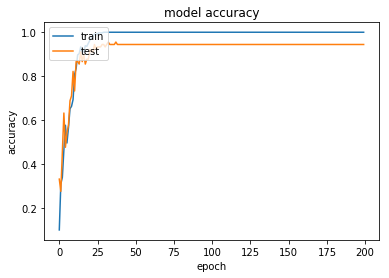

In [26]:
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

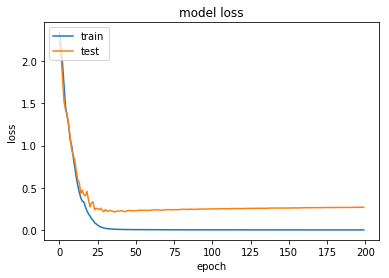

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [28]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
%ls

 Volume in drive C is Windows
 Volume Serial Number is 7252-C405

 Directory of C:\Users\cobalt\workspace\FaceRecognition

09/24/2017  05:19 PM    <DIR>          .
09/24/2017  05:19 PM    <DIR>          ..
09/24/2017  05:19 PM    <DIR>          .ipynb_checkpoints
09/24/2017  05:19 PM         1,125,355 FaceRecognitionLeNet.ipynb
09/24/2017  05:19 PM         1,125,355 FaceRecognitionLeNetv2.ipynb
09/24/2017  09:59 AM    <DIR>          front_database
09/24/2017  05:00 PM         5,049,496 model.h5
09/24/2017  05:19 PM             3,146 model.json
09/24/2017  03:32 PM         1,134,255 ReadMultipleImages.ipynb
04/13/2016  11:59 AM         4,373,288 Revised Final Thesis Draft.pdf
09/24/2017  10:00 AM    <DIR>          side_database
09/24/2017  10:00 AM    <DIR>          videos
               6 File(s)     12,810,895 bytes
               6 Dir(s)  199,579,463,680 bytes free


In [29]:
model.save_weights("model.h5")
%ls

 Volume in drive C is Windows
 Volume Serial Number is 7252-C405

 Directory of C:\Users\cobalt\workspace\FaceRecognition

09/24/2017  05:19 PM    <DIR>          .
09/24/2017  05:19 PM    <DIR>          ..
09/24/2017  05:19 PM    <DIR>          .ipynb_checkpoints
09/24/2017  05:19 PM         1,125,355 FaceRecognitionLeNet.ipynb
09/24/2017  05:19 PM         1,125,355 FaceRecognitionLeNetv2.ipynb
09/24/2017  09:59 AM    <DIR>          front_database
09/24/2017  05:19 PM         5,049,496 model.h5
09/24/2017  05:19 PM             3,146 model.json
09/24/2017  03:32 PM         1,134,255 ReadMultipleImages.ipynb
04/13/2016  11:59 AM         4,373,288 Revised Final Thesis Draft.pdf
09/24/2017  10:00 AM    <DIR>          side_database
09/24/2017  10:00 AM    <DIR>          videos
               6 File(s)     12,810,895 bytes
               6 Dir(s)  199,579,463,680 bytes free


In [30]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("model.h5")

In [31]:
loaded_model.compile(loss='categorical_crossentropy',
              optimizer=OPTIMIZER,
              metrics=['accuracy'])
score = loaded_model.evaluate(testData, testLabels, verbose=VERBOSE)
print("\nTest score:", score[0])
print('Test accuracy:', score[1])

50/50 [==============================] - 0s     

Test score: 0.666664040089
Test accuracy: 0.899999990463
